In [1]:
#public data annotation
import os
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import numpy as np
import useful_functions as uf
import scvi
sc.set_figure_params(figsize=(3,3), fontsize= 5, dpi = 100)
import sys
print(sys.executable)
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
print(datetime.now(tz=None))

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be

/home/jovyan/my-conda-envs/myenv/bin/python
2023-03-08 15:00:52.664087


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(pd.__version__)
print(scvi.__version__)
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')


1.9.1
0.8.0
1.5.1
0.19.0


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data')
adata = sc.read_h5ad("./trained/public_data/integrated_scanvi_kidney_model/adata.h5ad")

In [4]:
adata.obs['dataset'].value_counts()

kpmp       110346
stewart     29942
kuppe       19491
li          11811
Name: dataset, dtype: int64

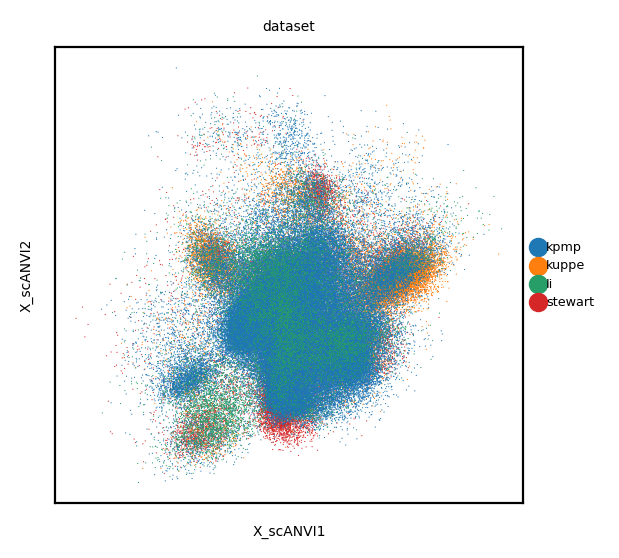

In [5]:
sc.pl.embedding(adata, basis = 'X_scANVI', color = 'dataset')

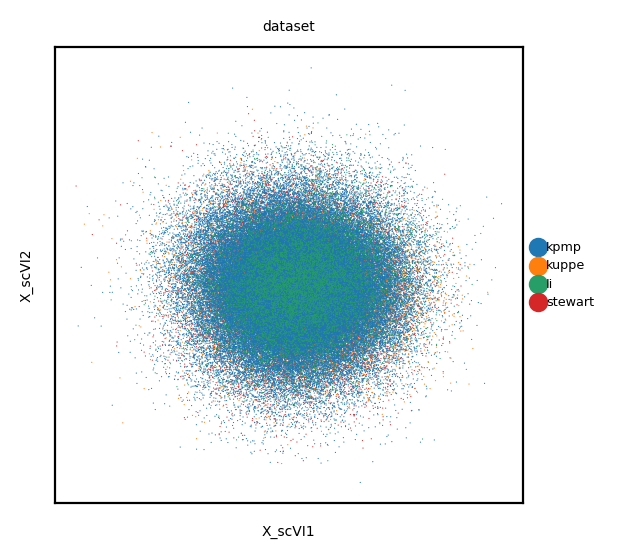

In [6]:
sc.pl.embedding(adata, basis = 'X_scVI', color = 'dataset')

In [7]:
from geosketch import gs
N = 20000 # Number of samples to obtain from the data set.
sketch_index = gs(adata.obsm['X_scVI'], N, replace=False)

In [8]:
#adata = adata[sketch_index].copy()

In [9]:
sc.pp.neighbors(adata, use_rep = 'X_scVI', n_neighbors = 10)

In [10]:
sc.tl.leiden(adata, resolution =1, key_added = 'leiden')

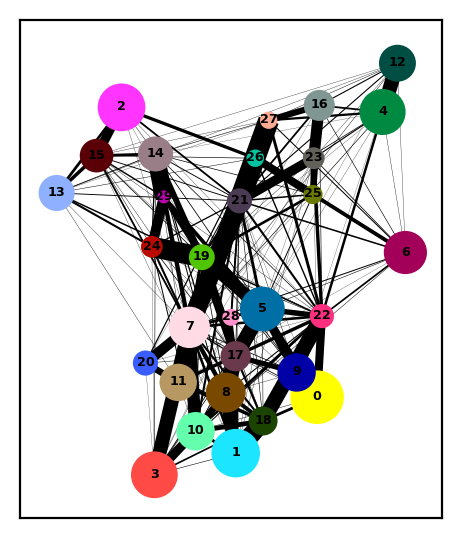

In [11]:
#do paga on the basis of the cell types
sc.tl.paga(adata, groups = 'leiden')
#plot paga
sc.pl.paga(adata, layout = 'fa')

In [12]:
sc.tl.umap(adata, min_dist = 0.3, init_pos = 'paga')

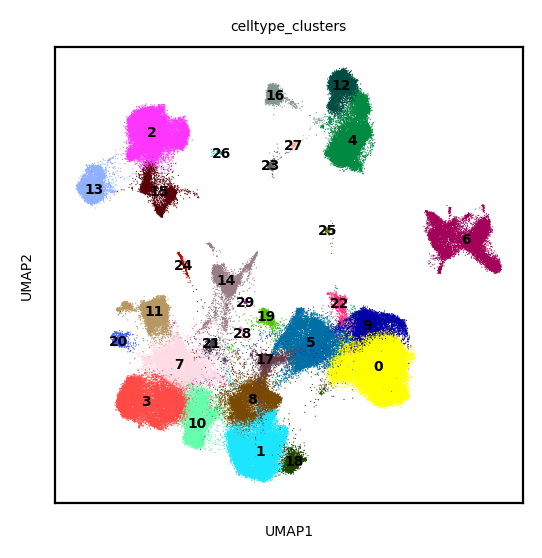

In [13]:
adata.obs['celltype_clusters'] = adata.obs['leiden']
sc.pl.umap(adata, color = 'celltype_clusters', legend_loc = 'on data')

In [14]:
#there are some clusters to 'recluster'
adata.obs['celltype_clusters'] = adata.obs['leiden']
reclusters = list(['6', '4', '15', '14'])
for cl in reclusters:
    sc.tl.leiden(adata, resolution = 0.4, restrict_to = ('celltype_clusters', [cl]))
    adata.obs['celltype_clusters'] = adata.obs['leiden_R']

reclusters = list(['12', '11', '2', '16', '21', '28'])
for cl in reclusters:
    sc.tl.leiden(adata, resolution = 0.2, restrict_to = ('celltype_clusters', [cl]))
    adata.obs['celltype_clusters'] = adata.obs['leiden_R']

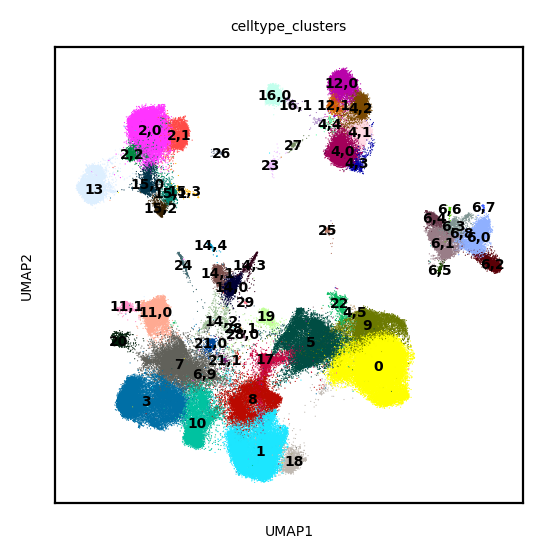

In [15]:
sc.pl.umap(adata, color = 'celltype_clusters', legend_loc = 'on data')

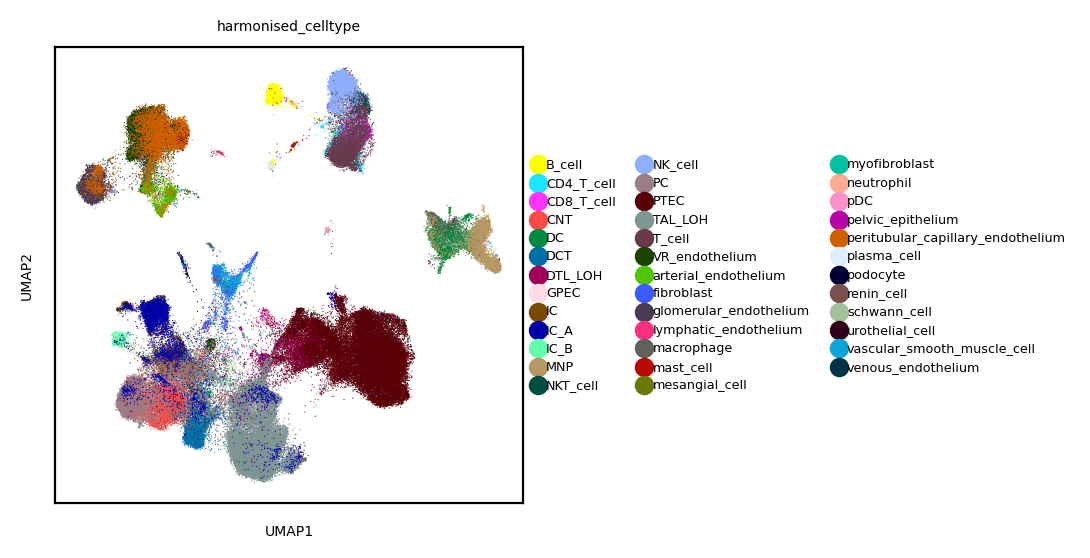

In [16]:
sc.pl.umap(adata, color = 'harmonised_celltype')

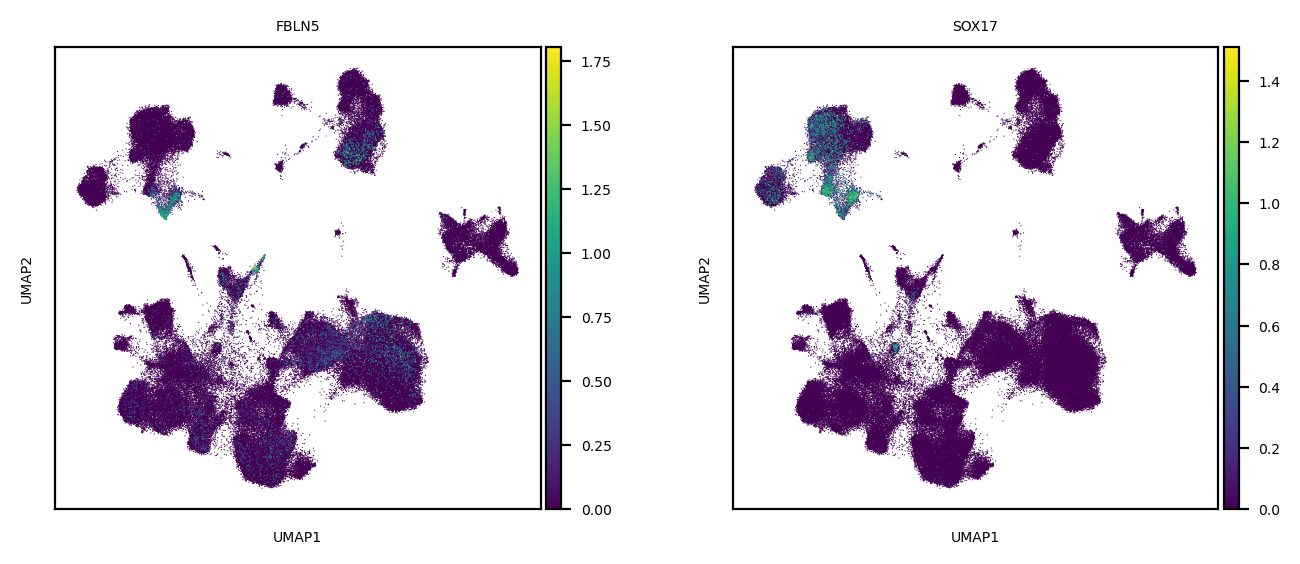

In [17]:
sc.pl.umap(adata, color = ['FBLN5', 'SOX17'])

categories: 2,0, 2,1, 2,2, etc.
var_group_labels: arterial, PCE, aff_ae, etc.


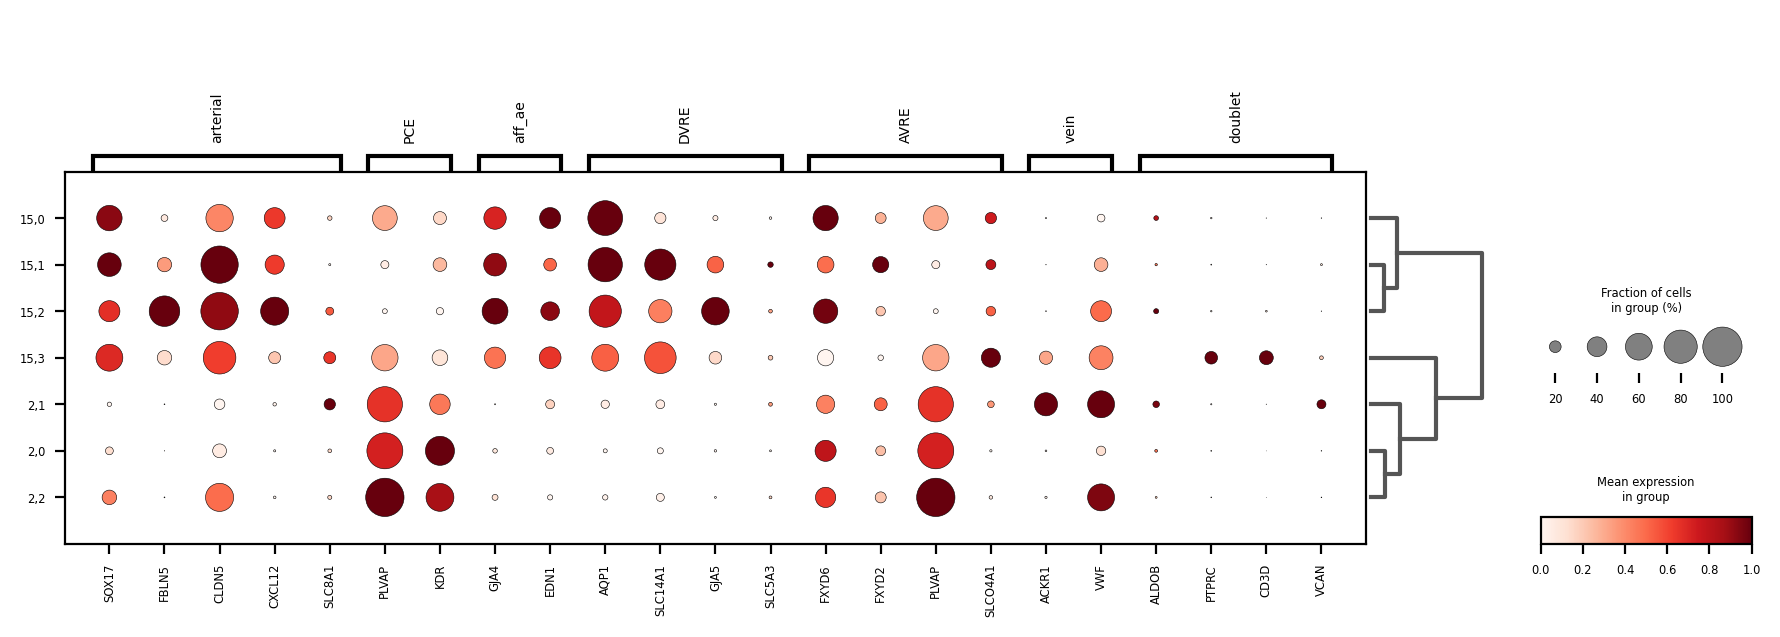

In [18]:
endo = adata[adata.obs['leiden'].isin(['2', '15'])]
sc.tl.dendrogram(endo, groupby = 'celltype_clusters')
sc.pl.dotplot(endo, dendrogram = True,
             var_names = {
                 'arterial' : ['SOX17', 'FBLN5', 'CLDN5', 'CXCL12', 'SLC8A1'],
                  'PCE' : ['PLVAP', 'KDR'], 
                     'aff_ae' : ['GJA4', 'EDN1'], 
                    'DVRE' : [ 'AQP1', 'SLC14A1', 'GJA5', 'SLC5A3'],
                    'AVRE' : ['FXYD6', 'FXYD2', 'PLVAP', 'SLCO4A1'], 
             'vein' : ['ACKR1', 'VWF'], 
             'doublet' : ['ALDOB', 'PTPRC', 'CD3D', 'VCAN']},
             groupby = 'celltype_clusters', standard_scale = 'var')

In [19]:
#do geosketch 
from geosketch import gs
N = 50000 # Number of samples to obtain from the data set.
sketch_index = gs(adata.obsm['X_scVI'], N, replace=False)
markers = uf.get_markers(adata[sketch_index], 'celltype_clusters', layer = 'counts')

100% (58 of 58) |########################| Elapsed Time: 0:04:09 Time:  0:04:09


In [20]:
markers['15,2'].head(10)

GeneFrequency  GeneFrequencyGlobal  GeneExpressionInCluster  \
Symbol                                                                  
FBLN2          0.834667              0.02142                 0.664272   
SULF1          0.645333              0.01172                 0.459902   
IL33           0.568000              0.01138                 0.380906   
SEMA3G         0.688000              0.02576                 0.476253   
CLDN5          0.920000              0.06708                 0.804031   
FBLN5          0.712000              0.03362                 0.527162   
SERPINE2       0.885333              0.07370                 0.807864   
CAV1           0.842667              0.07664                 0.663733   
GJA5           0.589333              0.02656                 0.402709   
CLEC14A        0.768000              0.06532                 0.592547   

          GeneExpressionOutsideCluster  GeneExpressionGlobal       idf  \
Symbol                                                                   
FBLN2                         0.010672              0.015575  3.843430   
SULF1                         0.004158              0.007576  4.446458   
IL33                          0.004647              0.007469  4.475898   
SEMA3G                        0.014021              0.017488  3.658932   
CLDN5                         0.048568              0.054234  2.701869   
FBLN5                         0.020064              0.023867  3.392634   
SERPINE2                      0.051784              0.057455  2.607752   
CAV1                          0.049305              0.053914  2.568636   
GJA5                          0.015778              0.018680  3.628349   
CLEC14A                       0.041993              0.046123  2.728457   

             tfidf           pval      adj_pvals  
Symbol                                            
FBLN2     3.207983   6.204881e-37   5.153819e-36  
SULF1     2.869448  9.778414e-163  8.485251e-162  
IL33      2.542310  2.651565e-219  2.377601e-218  
SEMA3G    2.517345   3.895326e-93   3.316955e-92  
CLDN5     2.485720   1.350666e-01   1.000000e+00  
FBLN5     2.415556   1.104424e-69   9.277598e-69  
SERPINE2  2.308730   1.595072e-03   1.294004e-02  
CAV1      2.164504   4.916792e-08   4.016280e-07  
GJA5      2.138307  3.788310e-142  3.265770e-141  
CLEC14A   2.095455   3.534666e-26   2.913430e-25

In [21]:
celltype_map = {"0" : "convoluted_PTEC", #SLC5A2 #SLC2A2 #SLC5A2 #SLC37A4
               "1" : "cortical_TAL_LOH",  #CLDN16
               "2,0" : "PCE", #PLVAP
               "2,1" : "VE", 
                "2,2" : "eff_AE",
                "3" : "PC", #AQP2
                "4,0" : "naive_CD4_T_cell",
                "4,1" : "activated_CD4_T_cell", #CD69, GZMK
                "4,2" : "CD8_T_cell",
                "4,3": "Treg",
                "4,4" : "ILC",
                "4,5"  : "doublet",  
                "5" :  "injured_PTEC", #VCAM1 #HAVCR1 
                "6,0" :  "classical_monocyte",
                "6,1" :  "cDC2",
                "6,2" : "nonclassical_monocyte",
                "6,3"  : "monocyte_derived_macrophage",
                "6,4" : "tissue_macrophage",
                "6,5" : "cDC1",
                "6,6" : "aDC",
                "6,7" : "neutrophil",
                "6,8" : "classical_monocyte",
                "6,9" :  "doublet",
                "7" : "CNT",
                "8" :  "medullary_TAL_LOH", 
                "9" : "straight_PTEC", #SLC5A8 #SLC5A10 #SLC5A1,
                "10" : "DCT",
                "11,0"  : "IC_A", #SLC4A1
                "11,1" : "low_quality",
                "12,0" : "NK1",
                "12,1" : "NK2",
               "13" : "GEC", 
                "14,0"  : "cortical_myofibroblast",
                "14,1" :  "cortical_myofibroblast",
                "14,2" : "doublet",
                "14,3" :  "cortical_fibroblast",
                "14,4"  : "MC",
               "15,0" : "AVRE", #PLVAP VRE
                "15,1" : "DVRE", #SLC14A1
                "15,2" :  "AE",
                "15,3" : "doublet",
               "16,0" : "B_cell",
               "16,1" : "doublet",
               "17" : "DTL_LOH" ,
                "18" : "low_quality",
                "19" : "GPEC",
                "20" :  "IC_B", #SLC4A9
                "21,0" : "doublet",
                "21,1" : "low_quality",
               "22" : "low_quality", 
               "23" : "plasma_cell",
                "24" : "podocyte",
                "25" : "pDC",
                "26" :  "lymphatic_endothelium", #CCL21 #PROX1
                "27" : "mast_cell",
               "28,0" : "PE",
                "28,1" : "urothelium", #UPK1A #S100P #TP63 #GPX2
               "29" : "schwann_cell"}
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['celltype_clusters'].map(celltype_map).astype('category')

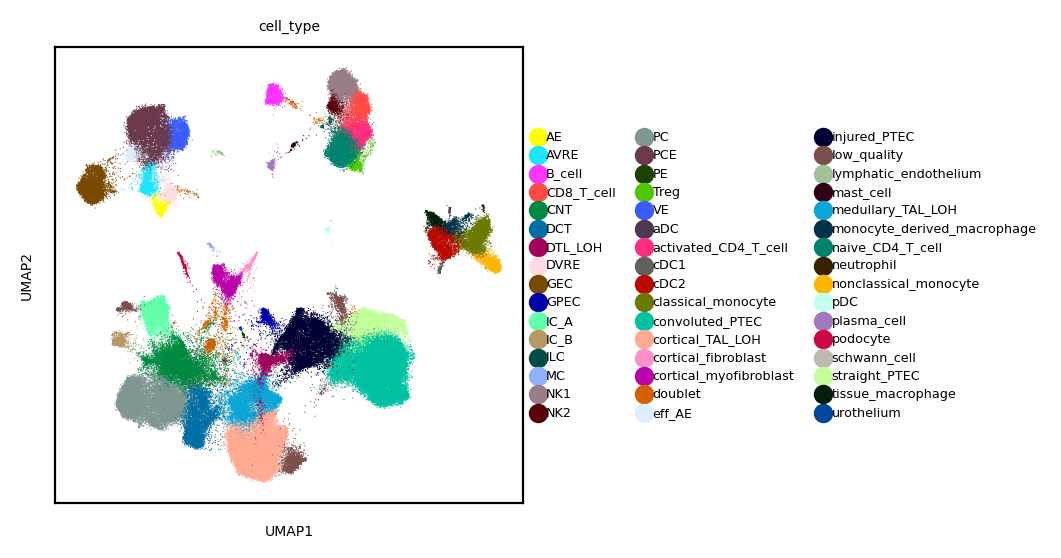

In [22]:
sc.pl.umap(adata, color = 'cell_type')

In [23]:
#remove doublets
adata = adata[~adata.obs['cell_type'].isin(['doublet'])]
adata = adata[~adata.obs['cell_type'].isin(['low_quality'])]

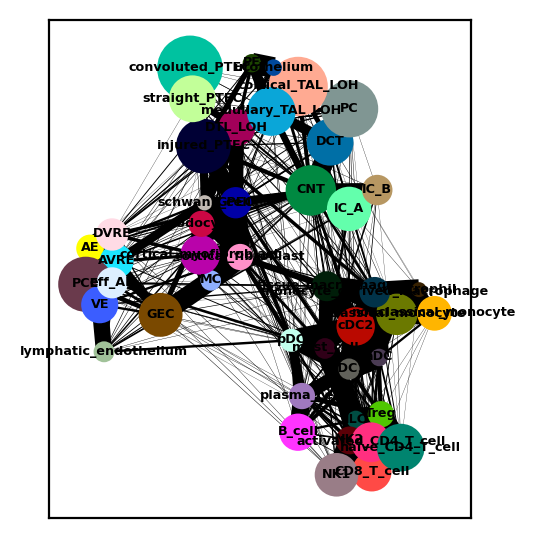

In [24]:
#recompute neighbors and a PAGA umap embedding
sc.pp.neighbors(adata, use_rep = 'X_scVI', n_neighbors = 30) #we plot the neighbors using scVI
#do paga on the basis of the cell type annotations
sc.tl.paga(adata, groups = 'cell_type')
#plot paga
sc.pl.paga(adata, layout = 'fa')

In [25]:
#recompute umap
sc.tl.umap(adata, init_pos = 'paga', min_dist = 0.4)

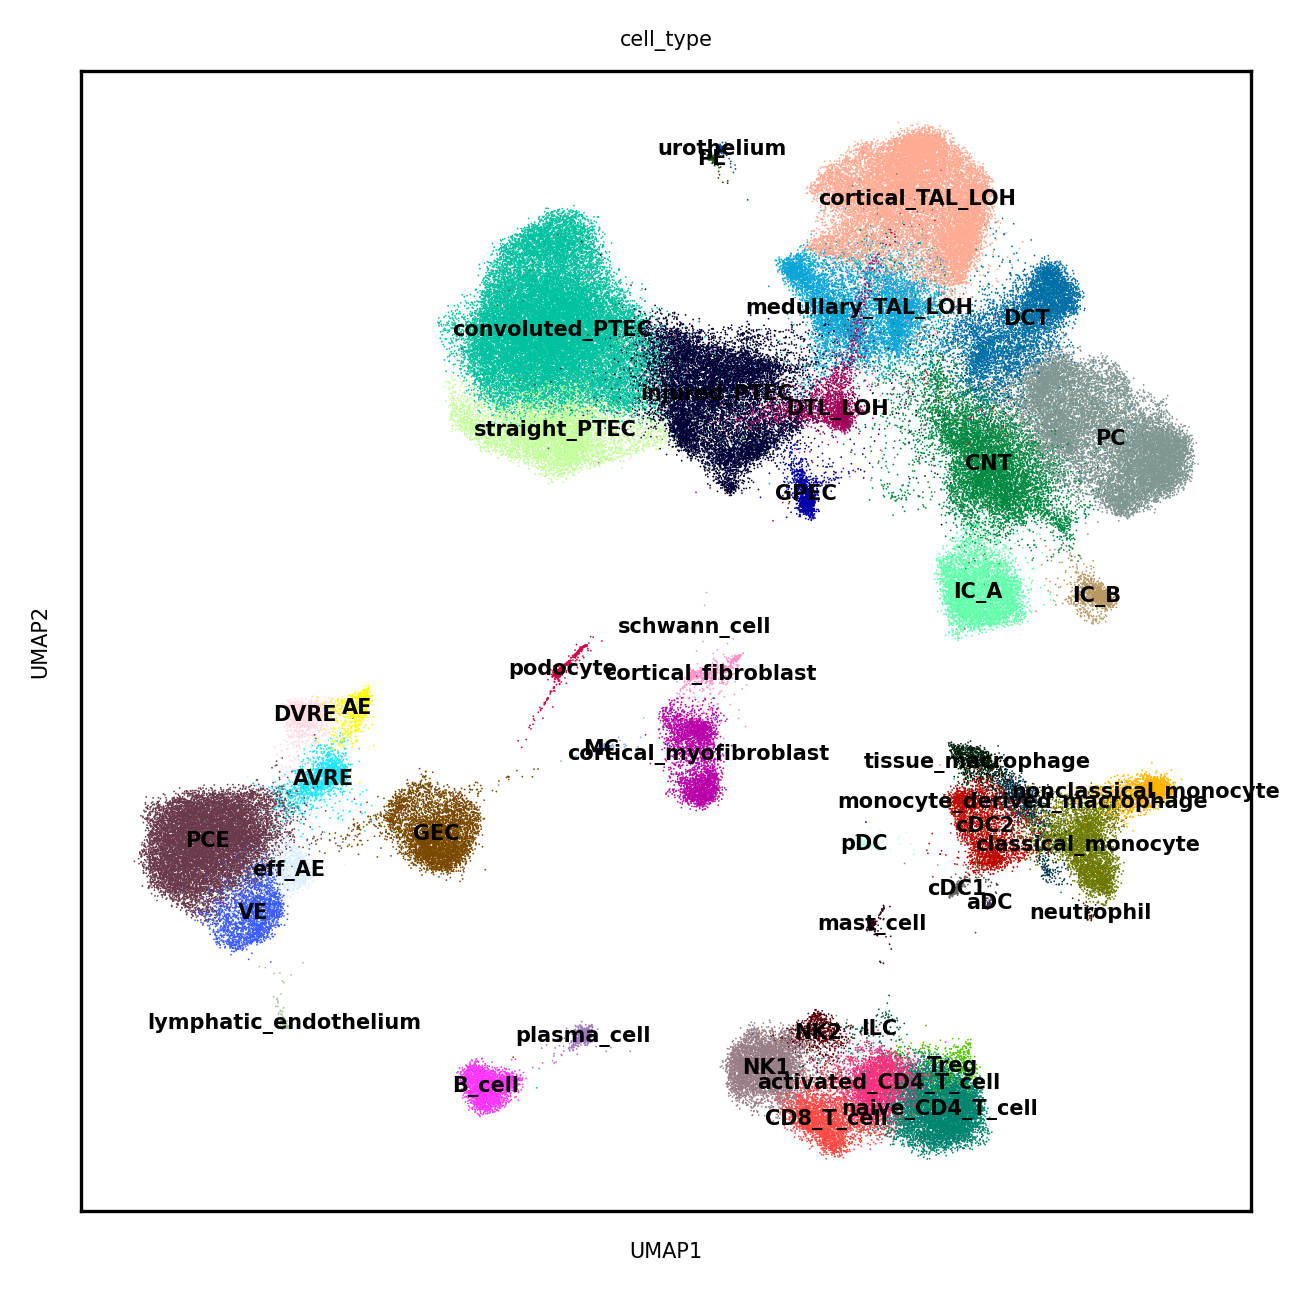

In [26]:
sc.set_figure_params(figsize=(5,5), fontsize= 5, dpi =150)
sc.pl.umap(adata, color = 'cell_type', legend_loc = 'on data')

In [27]:
#make the cell types categorical
ct_categories = ['podocyte',
'convoluted_PTEC',
'straight_PTEC', 
'injured_PTEC',
'GPEC', 
'DTL_LOH',
'medullary_TAL_LOH',
'cortical_TAL_LOH',
'DCT', 
'CNT', 
'PC', 
'IC_A', 
'IC_B',
'urothelium',
'PE', 
'AE', 
'GEC', 
'eff_AE',
'DVRE',
'AVRE', 
'PCE', 
'VE', 
'lymphatic_endothelium', 
'MC', 
'cortical_myofibroblast', 
'cortical_fibroblast',
'schwann_cell', 
'B_cell', 
'plasma_cell',
'naive_CD4_T_cell', 
'activated_CD4_T_cell',
'Treg', 
'CD8_T_cell', 
'ILC', 
'NK1', 
'NK2',
'cDC1', 
'cDC2', 
'aDC',
'pDC',
'classical_monocyte', 
'nonclassical_monocyte',
'monocyte_derived_macrophage', 
'tissue_macrophage',
'neutrophil',
'mast_cell'
]
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], categories=ct_categories)

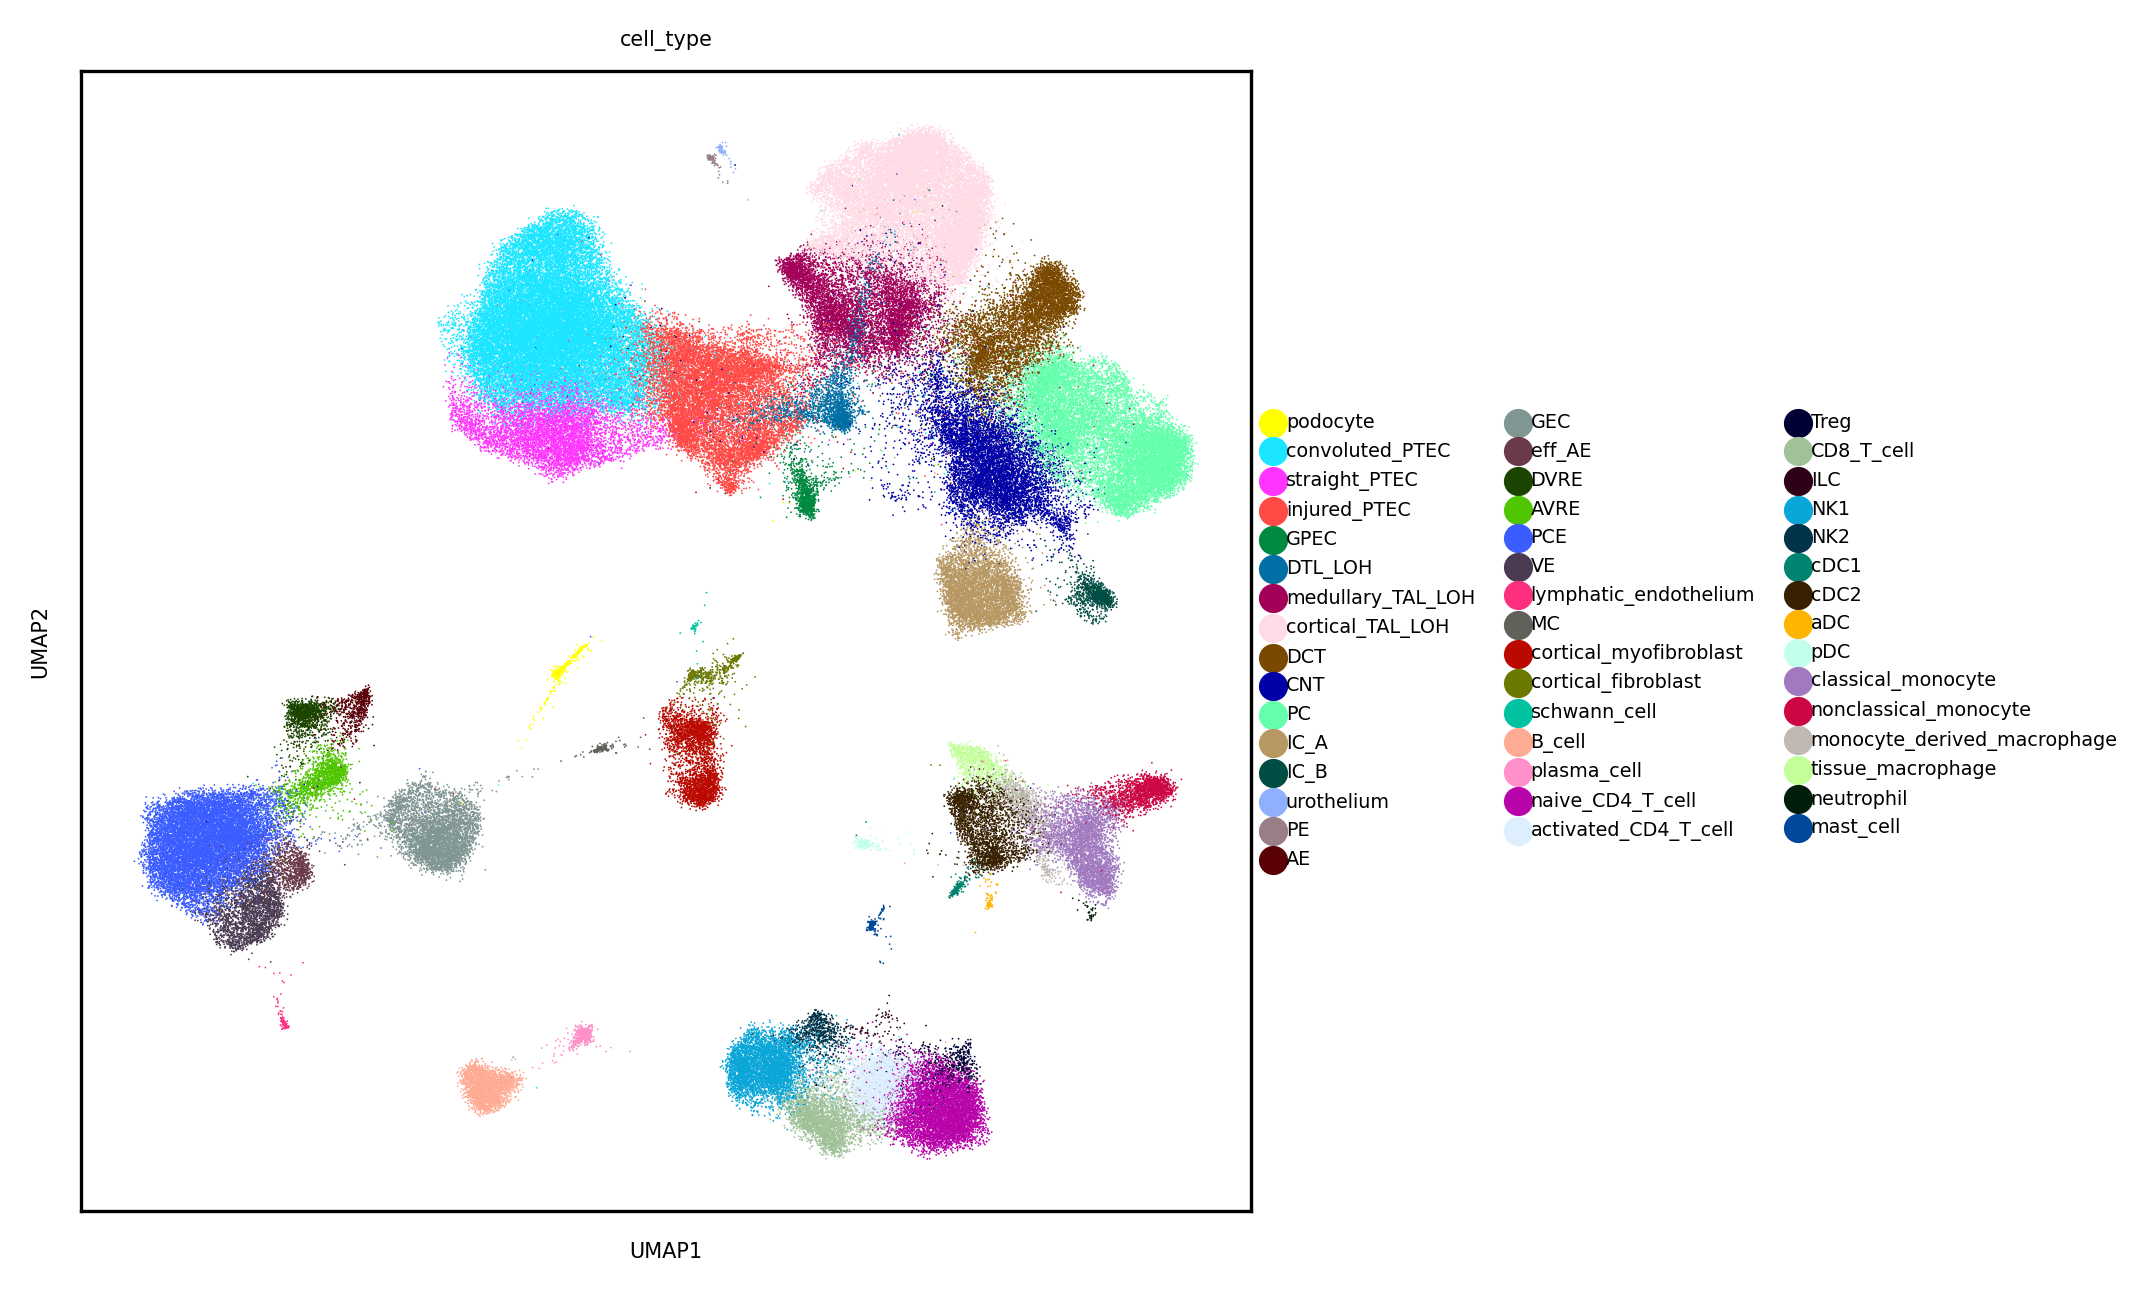

In [28]:
sc.pl.umap(adata, color = 'cell_type')

In [29]:
#save this 
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
adata.write_h5ad("./data/annotated/public_kidney.h5ad")